In [1]:
# variable for whether running on colab or not
running_on_colab = True

In [2]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    import subprocess
    subprocess.run("pip install pyrsgis", shell=True)
    subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"
    
saveTrainingData = False
loadTrainingData = True
data_model_base_path = "/content/drive/MyDrive/MangroveClassification/Data_and_Models/"
    
saveModel = False
loadModel = True
    
kSize = 7
stride = 1

print('Loading model: ', loadModel)
if not loadModel:
    print('Saving model: ', saveModel)
    print('Loading training data: ', loadTrainingData)
    print('Saving training data: ', saveTrainingData)

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7
Loading model:  True


In [48]:
# generate training data from chosen images or load it in

if not loadModel: # skip all of this if loading a saved and already fitted model

    if (loadTrainingData or saveTrainingData) and not running_on_colab:
        raise Exception("Trying to load or save training data, but not running on Google Colab.")

    if loadTrainingData:
        print('Loading training data from Google Drive.')
        model_input_data = np.load(data_model_base_path + 'saved_training_features.npy')
        model_input_labels = np.load(data_model_base_path + 'saved_training_labels.npy')
        print('Training data loaded with shapes:', model_input_data.shape, model_input_labels.shape)

    else:
        print('Generating new training data.')
        training_images = []
        training_images.append(image_base_path + "Florida_1_2000.tif")
        training_images.append(image_base_path + "Florida_3_2000.tif")
        # training_images.append(image_base_path + "Brazil_2_2000.tif")

        model_input_data, model_input_labels = diu.loadTrainingImagesCNN(training_images, downsampleMajority, kSize, stride)

        if saveTrainingData:
            print('Saving training data to Google Drive.')
            np.save(data_model_base_path + 'saved_training_features.npy', model_input_data)
            np.save(data_model_base_path + 'saved_training_labels.npy', model_input_labels)
            print('Done saving.')


In [49]:
if not loadModel: # skip this if loading a saved and already fitted model
    
    # split the data
    xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)
    print(xTrain.shape)
    print(xTest.shape)

    # delete some variables to clear up memory
    del model_input_data
    del model_input_labels

In [50]:
if saveModel and loadModel:
    raise Exception("Shouldn't save and load model at the same time.")

if loadModel:
    model = tf.keras.models.load_model(data_model_base_path + 'CNN_Model_F1_0.928_AUC_0.994.h5') # have to choose which model, could potentially grab the "best" one numerically
    print(model.summary())
    
else:
    # Define the parameters of the model
    model = keras.Sequential()
    model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(kSize, kSize, nBands)))
    model.add(Dropout(0.25))
    model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Define the accuracy metrics and parameters
    model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    # fit the model
    history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 7, 32)          256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 48)          1584      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                150592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [35]:
# print(history.history)

# could make some plots of the metrics/convergance - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

Confusion matrix:
 [[510016  13075]
 [  7222 129889]]

P-Score: 0.909, R-Score: 0.947
Accuracy: 0.969
f1: 0.928
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    523091
         1.0       0.91      0.95      0.93    137111

    accuracy                           0.97    660202
   macro avg       0.95      0.96      0.95    660202
weighted avg       0.97      0.97      0.97    660202



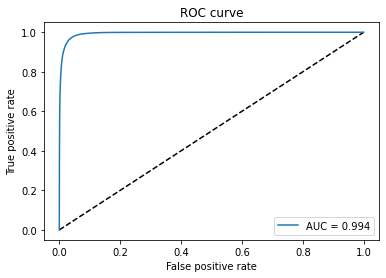

In [36]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

f1_score = peu.printClassificationMetrics(yTest, yTest_pred_prob)
auc_score = peu.makeROCPlot(yTest, yTest_pred_prob)

In [41]:
if saveModel:
    model.save(data_model_base_path + 'CNN_Model_F1_%.3f_AUC_%.3f.h5' % (f1_score, auc_score))

Predicting for image: /content/drive/MyDrive/MangroveClassification/Images/Brazil_1_2000.tif

Image NDVI band:


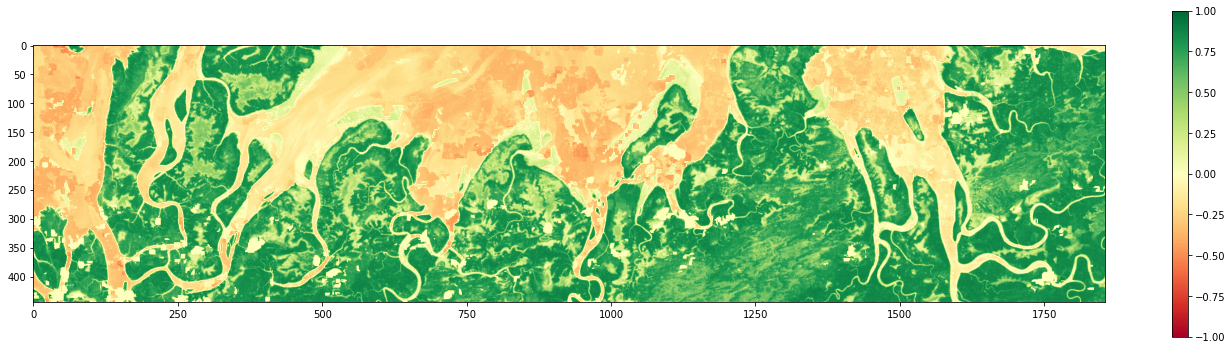


Label mangroves from 2000 data:


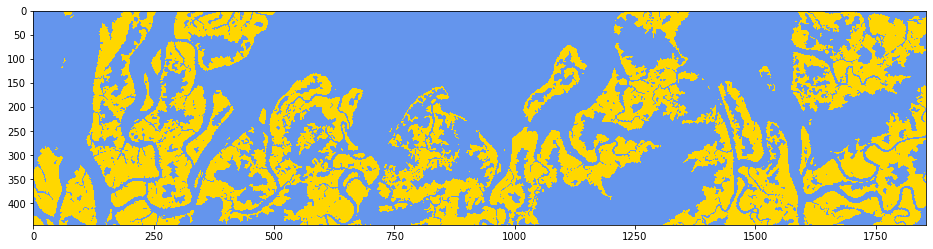

Confusion matrix:
 [[492210  44113]
 [ 37809 251343]]

P-Score: 0.851, R-Score: 0.869
Accuracy: 0.901
f1: 0.860
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    536323
           1       0.85      0.87      0.86    289152

    accuracy                           0.90    825475
   macro avg       0.89      0.89      0.89    825475
weighted avg       0.90      0.90      0.90    825475



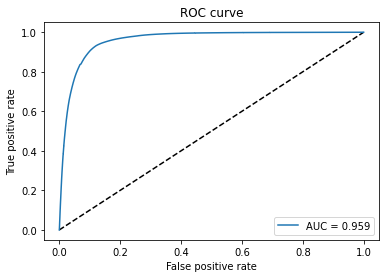


Predicted mangroves:


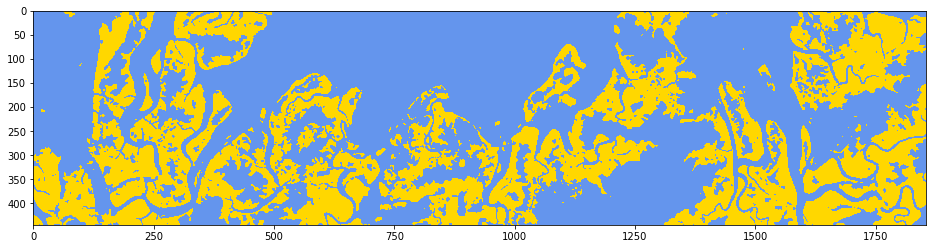


Difference between predicted and labeled mangroves:


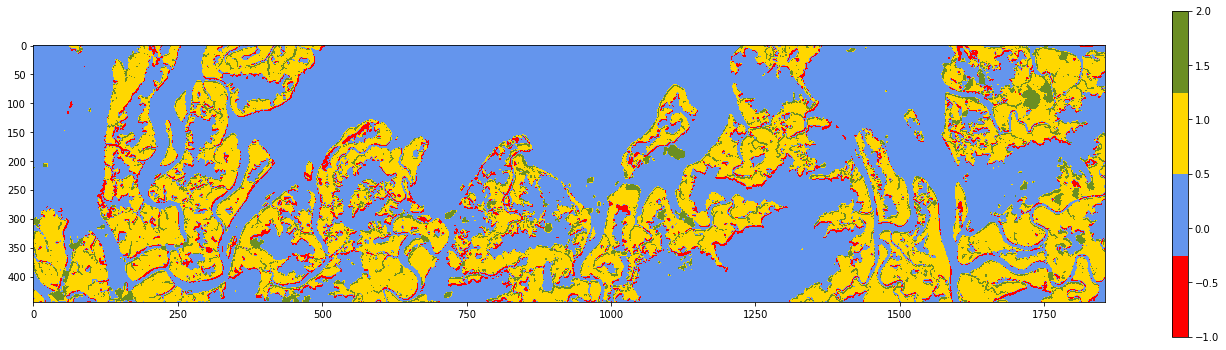

In [21]:
# apply model to new images
# diu.predictOnImageCNN(model, image_base_path + "Florida_1_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_3_2020.tif", kSize)
diu.predictOnImageCNN(model, image_base_path + "Brazil_1_2000.tif", kSize)


In [22]:
print('not now timeout!')

not now timeout!
